Load dataset and required packages:

In [ ]:
!wget https://storage.googleapis.com/nicksdemobucket/temperatures.csv

--2022-04-16 18:57:53--  https://storage.googleapis.com/nicksdemobucket/temperatures.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/csv]
Saving to: ‘temperatures.csv’

temperatures.csv    100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2022-04-16 18:57:54 (65.5 MB/s) - ‘temperatures.csv’ saved [67921/67921]



In [ ]:
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense ,Dropout, Bidirectional, GRU, TimeDistributed

Explore data:

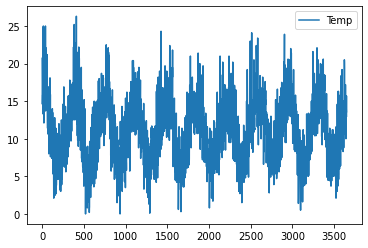

In [ ]:
df = pd.read_csv('temperatures.csv')

df.plot()

Generate training, test, and validation datasets:

In [ ]:
# Use the "sliding window" method to generate a time series dataset
def gen_time_series(sequence, total_len):
  series_list = []
  for i in range(len(sequence)):
    end_ix = i + total_len

    if end_ix > len(sequence):
      break

    series = sequence[i:end_ix]
    series_list.append(series)

  return np.array(series_list)[..., np.newaxis].astype(np.float32)
  

In [ ]:
num_steps = 50
forcast_steps = 10
total_len = num_steps + forcast_steps
series_set = gen_time_series(df['Temp'], total_len)
series_set.shape

(3591, 60, 1)

In [ ]:
np.random.seed(42)

# Create a training, test, and validation dataset

X_train = series_set[:2500, :num_steps]
X_valid = series_set[2500:3000, :num_steps]
X_test = series_set[3000:, :num_steps]
Y = np.empty((len(series_set), num_steps, forcast_steps))
for step_ahead in range(1, forcast_steps + 1):
  Y[..., step_ahead - 1] = series_set[..., step_ahead:step_ahead + num_steps, 0]
y_train = Y[:2500]
y_valid = Y[2500:3000]
y_test = Y[3000:]

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_test.shape, y_valid.shape

((2500, 50, 1),
 (500, 50, 1),
 (591, 50, 1),
 (2500, 50, 10),
 (591, 50, 10),
 (500, 50, 10))

Convert our datasets into a TensorFlow dataset:

In [ ]:
batch_size = 32

train_set= tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_set = train_set.shuffle(1000)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = valid_set.batch(batch_size).prefetch(1)
test_set = test_set.batch(batch_size).prefetch(1)

Design RNN Model #1

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',metrics=[last_time_step_mse])
 
history1 = model1.fit(train_set, epochs=20,
                    validation_data=(valid_set))


Epoch 1/20
79/79 [==============================] - 4s 22ms/step - loss: 42.8737 - last_time_step_mse: 41.7799 - val_loss: 18.2542 - val_last_time_step_mse: 17.9056
Epoch 2/20
79/79 [==============================] - 2s 20ms/step - loss: 16.2855 - last_time_step_mse: 15.8835 - val_loss: 18.5944 - val_last_time_step_mse: 18.2342
Epoch 3/20
79/79 [==============================] - 1s 18ms/step - loss: 13.1805 - last_time_step_mse: 12.6661 - val_loss: 10.5279 - val_last_time_step_mse: 10.2859
Epoch 4/20
79/79 [==============================] - 1s 19ms/step - loss: 9.6731 - last_time_step_mse: 9.2436 - val_loss: 8.9332 - val_last_time_step_mse: 8.8141
Epoch 5/20
79/79 [==============================] - 1s 19ms/step - loss: 9.4031 - last_time_step_mse: 9.1592 - val_loss: 8.7745 - val_last_time_step_mse: 8.5379
Epoch 6/20
79/79 [==============================] - 1s 19ms/step - loss: 9.1444 - last_time_step_mse: 8.8400 - val_loss: 8.5218 - val_last_time_step_mse: 8.2830
Epoch 7/20
79/79 [====

Plot actual data vs forcast from Model 1:

mse: tf.Tensor(4.7390184, shape=(), dtype=float32)


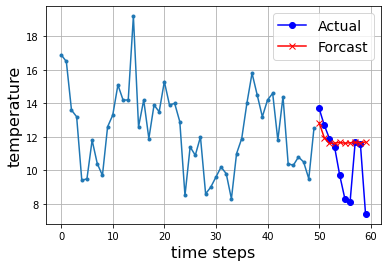

In [ ]:
X_test1 = X_test[0]
y_pred1 = model1.predict(X_test)[0][-1]
y_test1 = y_test[0][-1]
print('mse:', keras.metrics.mean_squared_error(y_test1, y_pred1))
plt.plot(np.arange(num_steps), X_test1, ".-")
plt.plot(np.arange(num_steps, num_steps + forcast_steps), y_test1, "bo-", label="Actual")
plt.plot(np.arange(num_steps, num_steps + forcast_steps), y_pred1, "rx-", label="Forcast")
plt.legend(fontsize=14, loc='upper right')
plt.xlabel("time steps", fontsize=16)
plt.ylabel("temperature", fontsize=16)
plt.grid(True)


Plot the performace of Model 1

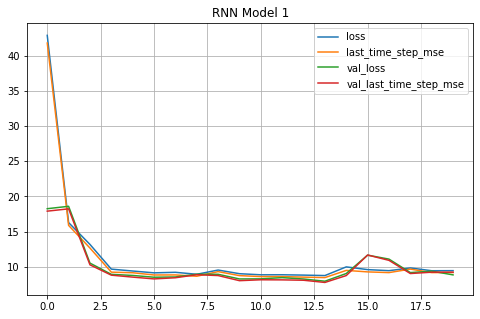

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid(True)
plt.title("RNN Model 1")
plt.show()

Design RNN Model #2

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)




model2 = keras.models.Sequential([
    keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(64, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))

])

# create an early stopping rule for fitting the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=[last_time_step_mse])
 
history2 = model2.fit(train_set, epochs=1000, batch_size=32,
                    validation_data=(valid_set),
                    callbacks=[early_stop])

Epoch 1/1000
79/79 [==============================] - 7s 60ms/step - loss: 70.1574 - last_time_step_mse: 65.4957 - val_loss: 27.6412 - val_last_time_step_mse: 11.0616
Epoch 2/1000
79/79 [==============================] - 7s 84ms/step - loss: 18.9036 - last_time_step_mse: 9.6927 - val_loss: 16.9075 - val_last_time_step_mse: 8.4093
Epoch 3/1000
79/79 [==============================] - 4s 56ms/step - loss: 14.0044 - last_time_step_mse: 8.7494 - val_loss: 13.2381 - val_last_time_step_mse: 8.1079
Epoch 4/1000
79/79 [==============================] - 4s 55ms/step - loss: 12.1056 - last_time_step_mse: 8.7423 - val_loss: 11.8077 - val_last_time_step_mse: 8.2949
Epoch 5/1000
79/79 [==============================] - 4s 55ms/step - loss: 11.0347 - last_time_step_mse: 8.5138 - val_loss: 10.4364 - val_last_time_step_mse: 7.9109
Epoch 6/1000
79/79 [==============================] - 4s 55ms/step - loss: 10.2671 - last_time_step_mse: 8.3947 - val_loss: 9.8964 - val_last_time_step_mse: 8.2124
Epoch 7/1

Plot actual data vs forcast from Model 2:

mse: tf.Tensor(7.1976624, shape=(), dtype=float32)


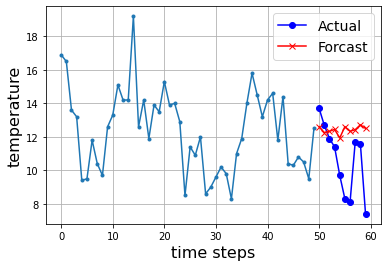

In [ ]:
X_test2 = X_test[0]
y_pred2 = model2.predict(X_test)[0][-1]
y_test2 = y_test[0][-1]
print('mse:', keras.metrics.mean_squared_error(y_test2, y_pred2))
plt.plot(np.arange(num_steps), X_test1, ".-")
plt.plot(np.arange(num_steps, num_steps + forcast_steps), y_test2, "bo-", label="Actual")
plt.plot(np.arange(num_steps, num_steps + forcast_steps), y_pred2, "rx-", label="Forcast")
plt.legend(fontsize=14, loc='upper right')
plt.xlabel("time steps", fontsize=16)
plt.ylabel("temperature", fontsize=16)
plt.grid(True)

Plot the performace of Model 2

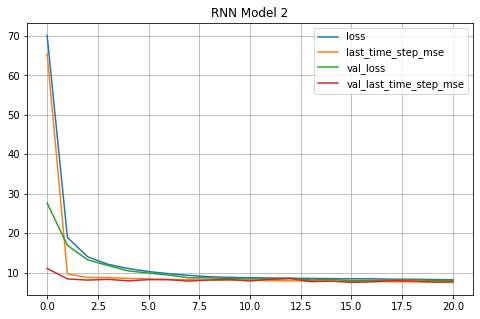

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.title("RNN Model 2")
plt.show()

Design RNN Model #3

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)




model3 = keras.models.Sequential([
    keras.layers.GRU(64, activation='relu', return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(64, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))

])

# create an early stopping rule for fitting the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=[last_time_step_mse])
 
history3 = model3.fit(train_set, epochs=1000, batch_size=32,
                    validation_data=(valid_set),
                    callbacks=[early_stop])

Epoch 1/1000
79/79 [==============================] - 10s 89ms/step - loss: 69.6430 - last_time_step_mse: 64.9728 - val_loss: 15.5584 - val_last_time_step_mse: 8.7033
Epoch 2/1000
79/79 [==============================] - 7s 85ms/step - loss: 12.8660 - last_time_step_mse: 9.0986 - val_loss: 11.7488 - val_last_time_step_mse: 7.9951
Epoch 3/1000
79/79 [==============================] - 8s 99ms/step - loss: 11.0970 - last_time_step_mse: 8.8139 - val_loss: 10.3692 - val_last_time_step_mse: 8.0077
Epoch 4/1000
79/79 [==============================] - 6s 78ms/step - loss: 10.1767 - last_time_step_mse: 8.6713 - val_loss: 9.5531 - val_last_time_step_mse: 7.9435
Epoch 5/1000
79/79 [==============================] - 4s 51ms/step - loss: 9.5432 - last_time_step_mse: 8.5873 - val_loss: 8.9731 - val_last_time_step_mse: 7.8715
Epoch 6/1000
79/79 [==============================] - 4s 53ms/step - loss: 9.1085 - last_time_step_mse: 8.4666 - val_loss: 8.6519 - val_last_time_step_mse: 7.8759
Epoch 7/1000


Plot actual data vs forcast from Model 3:

mse: tf.Tensor(4.564241, shape=(), dtype=float32)


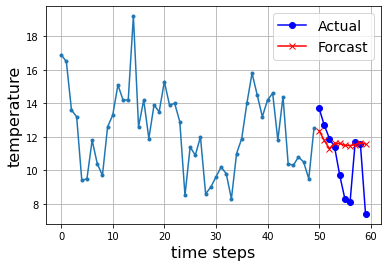

In [ ]:
X_test3 = X_test[0]
y_pred3 = model3.predict(X_test)[0][-1]
y_test3 = y_test[0][-1]
print('mse:', keras.metrics.mean_squared_error(y_test3, y_pred3))
plt.plot(np.arange(num_steps), X_test1, ".-")
plt.plot(np.arange(num_steps, num_steps + forcast_steps), y_test3, "bo-", label="Actual")
plt.plot(np.arange(num_steps, num_steps + forcast_steps), y_pred3, "rx-", label="Forcast")
plt.legend(fontsize=14, loc='upper right')
plt.xlabel("time steps", fontsize=16)
plt.ylabel("temperature", fontsize=16)
plt.grid(True)

Plot the performace of Model 3

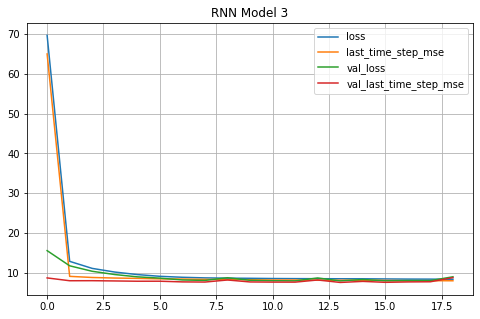

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid(True)
plt.title("RNN Model 3")
plt.show()